In [253]:
import numpy as np
import obspy
import scipy
from obspy import read
import matplotlib.pyplot as plt 
%matplotlib inline
import time
import pandas as pd

from __future__ import print_function
import tensorflow as tf
import keras
from keras.layers import add, Reshape, Dense,Input, TimeDistributed, Dropout, Activation, LSTM, Conv2D, Bidirectional, BatchNormalization 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping,ReduceLROnPlateau
from keras.regularizers import l1
from keras import backend as K
from keras.models import Model
from sklearn.model_selection import train_test_split
from scipy import signal
import os
np.seterr(divide='ignore', invalid='ignore')
import h5py
from obspy.signal.trigger import trigger_onset
np.warnings.filterwarnings('ignore')

## Grillo Data

In [301]:
s1 = read("data/signal/1512114894_015_P.mseed")
print(len(s1))

3


In [302]:
s1

3 Trace(s) in Stream:
.015..BHX | 2017-12-01T07:54:54.001000Z - 2017-12-01T07:55:57.969000Z | 31.2 Hz, 2000 samples
.015..BHY | 2017-12-01T07:54:54.001000Z - 2017-12-01T07:55:57.969000Z | 31.2 Hz, 2000 samples
.015..BHZ | 2017-12-01T07:54:54.001000Z - 2017-12-01T07:55:57.969000Z | 31.2 Hz, 2000 samples

In [303]:
s1.plot(outfile="signal1.png")

In [304]:
tr_s1 = s1[1]
trace_data = tr_s1.data
print(type(trace_data))
print(trace_data)

<class 'numpy.ndarray'>
[ 0.          0.01803802 -0.04592396 ...,  0.02292396  0.01096198
  0.        ]


In [305]:
len(trace_data)

2000

In [306]:
start_time = s1[0].stats.starttime
end_time = s1[0].stats.endtime
gap = (end_time - start_time)/4
s1 = s1.slice(start_time + gap, end_time - gap)

In [307]:
s1

3 Trace(s) in Stream:
.015..BHX | 2017-12-01T07:55:10.001000Z - 2017-12-01T07:55:41.969000Z | 31.2 Hz, 1000 samples
.015..BHY | 2017-12-01T07:55:10.001000Z - 2017-12-01T07:55:41.969000Z | 31.2 Hz, 1000 samples
.015..BHZ | 2017-12-01T07:55:10.001000Z - 2017-12-01T07:55:41.969000Z | 31.2 Hz, 1000 samples

### Detrend

In [308]:
s = s1.detrend("demean")

In [309]:
s[1].data

array([  4.12020048e-02,   2.32400238e-02,  -1.47219572e-02,
        -1.05683938e-01,  -1.86459192e-02,  -3.60790020e-03,
        -4.15698812e-02,   2.34681378e-02,  -1.44938432e-02,
         4.15441758e-02,   4.15821948e-02,  -1.83797861e-02,
        -3.34176713e-03,  -5.93037481e-02,  -1.35265729e-01,
        -2.62277101e-02,   1.58103089e-02,  -7.15167209e-03,
        -4.81136531e-02,  -3.70756341e-02,   5.39623849e-02,
         1.00040395e-03,  -5.19615770e-02,   1.07644197e-03,
        -2.18855390e-02,  -2.58475200e-02,  -4.78095010e-02,
         1.22285180e-02,   3.52665370e-02,  -9.69544397e-03,
         8.34257504e-03,   4.63805940e-02,   1.41861306e-03,
        -2.55433679e-02,  -6.25053489e-02,  -6.46732991e-03,
         2.05706891e-02,  -7.03912919e-02,  -4.73532729e-02,
        -4.33152539e-02,   1.67227651e-02,  -9.23921586e-03,
        -2.12011968e-02,   5.78368222e-02,   5.78748412e-02,
        -3.20871398e-02,  -3.60491208e-02,  -5.10111018e-02,
         4.30269172e-02,

In [310]:
len(s[1].data)

1000

### Bandpass filter between 1 and 45Hz

In [311]:
s = s.filter("bandpass", freqmin=1, freqmax=45)

In [312]:
s[1].data

array([  3.16667217e-02,   1.23732032e-03,  -3.28145303e-02,
        -9.04922026e-02,   2.26277127e-02,   3.30167918e-02,
        -4.16339198e-03,   5.42552134e-02,   4.17873238e-03,
         4.63012637e-02,   2.26336882e-02,  -4.10800512e-02,
        -1.78073032e-02,  -5.74379884e-02,  -9.01882217e-02,
         4.34544398e-02,   6.78833665e-02,   2.58889456e-02,
        -1.54719827e-02,   1.67472034e-03,   7.31690062e-02,
        -3.69858932e-03,  -4.99440945e-02,   8.68309310e-03,
        -1.66113633e-02,  -1.57240934e-02,  -2.76586683e-02,
         3.13284114e-02,   3.44151039e-02,  -2.02244398e-02,
        -2.57691716e-03,   2.29899286e-02,  -2.88643444e-02,
        -4.32565932e-02,  -5.49125759e-02,   1.63139325e-02,
         3.55109947e-02,  -4.68279609e-02,  -1.85089719e-03,
         1.17863459e-02,   6.31143483e-02,   2.15295147e-02,
         5.69983581e-03,   6.57247032e-02,   3.28394784e-02,
        -6.07682699e-02,  -4.48372718e-02,  -3.96644102e-02,
         5.15096153e-02,

In [313]:
len(s[1].data)

1000

### Resampled at 100 HZ

In [314]:
s = s.resample(100)

In [315]:
s[1].data

array([ 0.00050487,  0.00545162,  0.00620602, ..., -0.0233699 ,
       -0.01539152, -0.00700777])

In [316]:
len(s[1].data)

3200

### Normalize

In [317]:
s = s.normalize()

In [318]:
s[1].data

array([ 0.00020889,  0.0022556 ,  0.00256773, ..., -0.00966924,
       -0.00636821, -0.00289945])

In [319]:
len(s[1].data)

3200

In [320]:
s.plot(outfile="tf.png")

### STFT

In [331]:
f, t, Zxx = signal.stft(s, fs=100,nperseg=25)
print(Zxx.shape)

(3, 13, 248)


In [332]:
#Zxx = np.abs(Zxx)
#Zxx = Zxx.T
Zxx.shape

(3, 13, 248)

In [333]:
max(f),min(f)

(48.0, 0.0)

In [334]:
max(t)-min(t)

32.109999999999999

### Plot spectrogram

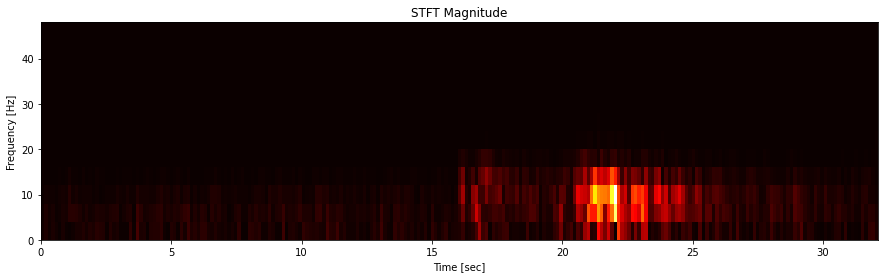

In [356]:
fig, ax = plt.subplots(figsize=(15, 4))
f, t, Zxx = signal.stft(s, fs=100,nperseg=25)
plt.pcolormesh(t, f, np.abs(Zxx[0,:,:]), shading='flat',cmap = 'hot')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Code

In [162]:
noise_filename = pd.read_csv('noise.csv', header = None)
noise_stream = []
for i in noise_filename[0]:
    temp = obspy.read("data/noise/" + i)
    noise_stream.append(temp)
    
signal_filename = pd.read_csv('signal.csv', header = None)
signal_stream = []
for i in signal_filename[0]:
    temp = obspy.read("data/signal/" + i)
    signal_stream.append(temp)

In [163]:
def slice_stream(st):
    start_time = st[0].stats.starttime
    end_time = st[0].stats.endtime
    gap = (end_time - start_time)/4
    st = st.slice(start_time + gap, end_time - gap)
    return st

In [164]:
noise_stream = list(map(slice_stream,noise_stream))
signal_stream = list(map(slice_stream,signal_stream))

In [165]:
noise_stream = [n.filter("bandpass", freqmin=1, freqmax=45) for n in noise_stream]
noise_stream = [n.resample(100) for n in noise_stream]
noise_stream = [n.detrend("demean") for n in noise_stream]
noise_stream = [n.normalize() for n in noise_stream]

In [166]:
signal_stream = [n.filter("bandpass", freqmin=1, freqmax=45) for n in signal_stream]
signal_stream = [n.resample(100) for n in signal_stream]
signal_stream = [n.detrend("demean") for n in signal_stream]
signal_stream = [n.normalize() for n in signal_stream]

In [167]:
len(noise_stream), len(signal_stream)

(17850, 1223)

In [168]:
signal_stream[0].plot(outfile="signal11.png")

In [169]:

## the time lap of the data is about 32 seconds and we would like to set the value appox. 0.5 sec before p-wave arrival
## and approx. 3 sec after p-wave arrival to be 1 and others be 0

'''
noise_y = np.zeros(shape = (noise_length, 62, 1))

signal_y_truth = np.append(np.append(np.zeros(shape=(31,1)), np.ones(shape=(6,1)),axis=0), np.zeros(shape=(25,1)),axis=0)
signal_y = np.zeros(shape = (signal_length, 62, 1))
for i in range(signal_length):
    signal_y[i] = signal_y_truth
'''



noise_length = len(noise_stream)
noise_y = np.zeros(shape = (noise_length, 62, 1))

signal_length = len(signal_stream)
signal_y_truth = np.append(np.zeros(shape=(31,1)), np.ones(shape=(31,1)),axis=0)
signal_y = np.zeros(shape = (signal_length, 62, 1))
for i in range(signal_length):
    signal_y[i] = signal_y_truth
    

In [170]:
f_signal = []
t_signal = []
Zxx_signal = np.zeros(shape = (signal_length, 248, 13, 3))

for i in range(signal_length):
    f, t, Zxx = signal.stft(signal_stream[i], fs = 100, nperseg=25)
    f_signal.append(f)
    t_signal.append(t)
    Zxx_signal[i] = np.abs(Zxx).T

f_noise = []
t_noise = []
Zxx_noise = np.zeros(shape = (noise_length, 248, 13, 3))

for i in range(noise_length):
    f, t, Zxx = signal.stft(noise_stream[i], fs = 100, nperseg=25)
    f_noise.append(f)
    t_noise.append(t)
    Zxx_noise[i] = np.abs(Zxx).T

In [171]:
y = np.append(noise_y, signal_y, axis = 0)
X_Zxx = np.append(Zxx_noise, Zxx_signal, axis = 0)

In [172]:
print(y.shape)
print(X_Zxx.shape)

(19073, 62, 1)
(19073, 248, 13, 3)


## Model CRED

In [173]:
def lr_schedule(epoch):
    """
    Learning rate is scheduled to be reduced after 40, 60, 80, 90 epochs.
    """
    lr = 1e-2
    if epoch > 60:
        lr *= 0.5e-3
    elif epoch > 40:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [174]:
def block_CNN(filters, ker, inpC): 
    """
    Returns CNN residual blocks
    """
    layer_1 = BatchNormalization()(inpC) 
    act_1 = Activation('relu')(layer_1) 

    conv_1 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_1) 
    
    layer_2 = BatchNormalization()(conv_1) 
    act_2 = Activation('relu')(layer_2) 
  
    conv_2 = Conv2D(filters, (ker-2, ker-2), padding = 'same')(act_2) 
    return(conv_2) 

In [175]:
def block_BiLSTM(inpR, filters, rnn_depth):
    """
    Returns LSTM residual blocks
    """
    x = inpR
    for i in range(rnn_depth):
        x_rnn = Bidirectional(LSTM(filters, return_sequences=True))(x)
        x_rnn = Dropout(0.7)(x_rnn)
        if i > 0 :
            x = add([x, x_rnn])
        else:
            x = x_rnn      
    return x
     

In [176]:
def model_cred(shape, filters):
    
    inp = Input(shape=shape, name='input')

    conv2D_2 = Conv2D(filters[0], (9,9), strides = (2,2), padding = 'same', activation = 'relu')(inp) 
    res_conv_2 = keras.layers.add([block_CNN(filters[0], 9, conv2D_2), conv2D_2]) 

    conv2D_3 = Conv2D(filters[1], (5,5), strides = (2,2), padding = 'same', activation = 'relu')(res_conv_2) 
    res_conv_3 = keras.layers.add([block_CNN(filters[1], 5, conv2D_3),conv2D_3]) 
    
    shape = K.int_shape(res_conv_3)   
    reshaped = Reshape((shape[1], shape[2]*shape[3]))(res_conv_3)
    
    res_BIlstm = block_BiLSTM(reshaped, filters = filters[3], rnn_depth = 2)
 
    UNIlstm = LSTM(filters[3], return_sequences=True)(res_BIlstm)
    UNIlstm = Dropout(0.8)(UNIlstm)  
    UNIlstm = BatchNormalization()(UNIlstm)
   
    dense_2 = TimeDistributed(Dense(filters[3], kernel_regularizer=l1(0.01), activation='relu'))(UNIlstm)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(0.8)(dense_2)
    
    dense_3 = TimeDistributed(Dense(1, kernel_regularizer=l1(0.01), activation='sigmoid'))(dense_2)

    out_model = Model(inputs=inp, outputs=dense_3)
    return out_model  

In [177]:
early_stopping_monitor = EarlyStopping(patience=5)
    
lr_scheduler = LearningRateScheduler(lr_schedule)
    
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=3,
                                   min_lr=0.5e-6)

In [178]:
model = model_cred((248, 13, 3), filters = [8, 16, 32, 64, 128, 256])
model.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(lr=lr_schedule(0)),
                  metrics=['binary_accuracy'])

model.summary()

Learning rate:  0.01
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 248, 13, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 124, 7, 8)    1952        ['input[0][0]']                  
                                                                                                  
 batch_normalization_36 (BatchN  (None, 124, 7, 8)   32          ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                       

In [179]:
seed_value = 15
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [180]:
X, X_test, y, y_test = train_test_split(X_Zxx, y, test_size=0.1, random_state=15,shuffle=True)

In [181]:
checkpointer = ModelCheckpoint(filepath='model_best.hdf5',
                                       monitor='val_loss', verbose=0, mode='auto', save_best_only=True)
start_time = time.time()  
history = model.fit(
    X,
    y,
    epochs=200,
    batch_size=500,
    verbose=0,
    validation_split = 0.2,
    max_queue_size=5,
    callbacks = [checkpointer, lr_reducer, lr_scheduler, early_stopping_monitor] )
end_time = time.time()

Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.01
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  0.0001
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05
Learning rate:  1e-05
L

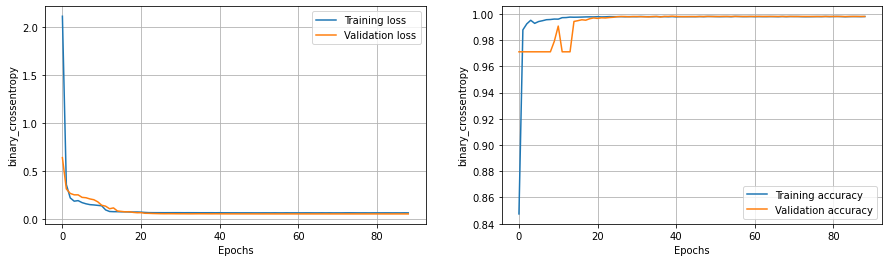

In [281]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 4))

axes[0].plot(history.history['loss'],label='Training loss')
axes[0].plot(history.history['val_loss'],label='Validation loss')
axes[0].set_ylabel('binary_crossentropy', fontsize=10)
axes[0].set_xlabel('Epochs', fontsize=10)
axes[0].legend()
axes[0].grid()

axes[1].plot(history.history['binary_accuracy'],label='Training accuracy')
axes[1].plot(history.history['val_binary_accuracy'],label='Validation accuracy')
axes[1].set_ylabel('binary_crossentropy', fontsize=10)
axes[1].set_xlabel('Epochs', fontsize=10)
axes[1].legend()
axes[1].grid()

In [185]:
model.load_weights('model_best.hdf5')
#y = model.predict(Zxx)
model.evaluate(X_test, y_test)

60/60 [==============================] - 4s 67ms/step - loss: 0.0481 - binary_accuracy: 0.9988


[0.04807717353105545, 0.9987996220588684]

In [186]:
y_pred = model.predict(X_test)

In [135]:
len(y_test[200])

62

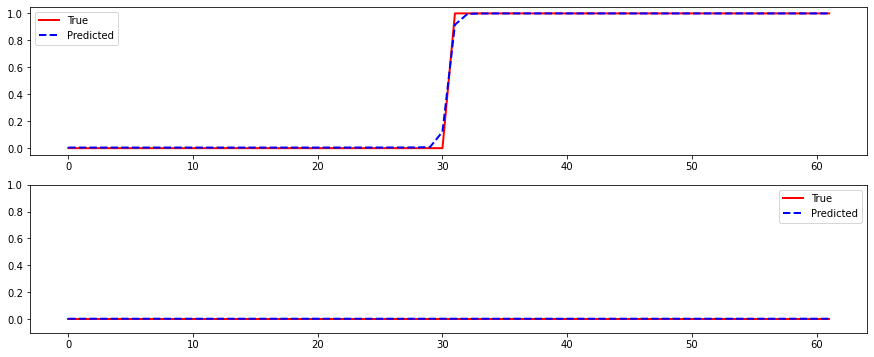

In [277]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(15, 6))
axes[0].plot(y_test[200].squeeze(), color='r', linewidth=2, label='True')
axes[0].plot(y_pred[200].squeeze(),'--', color='b', linewidth=2, label='Predicted')
axes[0].legend()

axes[1].plot(y_test[201].squeeze(), color='r', linewidth=2, label='True')
axes[1].plot(y_pred[201].squeeze(),'--', color='b', linewidth=2, label='Predicted')
axes[1].set_ylim(ymin=-0.1, ymax=1)
axes[1].legend()
plt.show()